In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

Using TensorFlow backend.


In [2]:
df = read_csv('dataset/irondata.csv')

In [3]:
df['date']=pd.to_datetime(df['date'],format='%d/%m/%Y')

In [4]:
df=df.sort_values('date')
df['Month']=df['date'].dt.month
df['price_lag']=df['price'].shift(1)
df['price_diff']=df['price_lag'].diff(periods=1)
df=df.set_index('date')
df['rolling_mean_price']=df['price_lag'].rolling(2, min_periods=1).sum()
df=df.dropna()
df.head()

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
1990-03-31,14.05,3,14.05,0.0,28.1
1990-04-30,14.05,4,14.05,0.0,28.1
1990-05-31,14.05,5,14.05,0.0,28.1
1990-06-30,14.05,6,14.05,0.0,28.1
1990-07-31,14.05,7,14.05,0.0,28.1


In [5]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['price'] = min_max_scaler.fit_transform(df.price.values.reshape(-1,1))
    df['Month'] = min_max_scaler.fit_transform(df.Month.values.reshape(-1,1))
    df['price_lag'] = min_max_scaler.fit_transform(df.price_lag.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [6]:
# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
1990-03-31,0.014795,0.181818,0.014795,0.0,0.01512
1990-04-30,0.014795,0.272727,0.014795,0.0,0.01512
1990-05-31,0.014795,0.363636,0.014795,0.0,0.01512
1990-06-30,0.014795,0.454545,0.014795,0.0,0.01512
1990-07-31,0.014795,0.545455,0.014795,0.0,0.01512


In [7]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    #print(data_raw.shape)
    data = []
    cnt = 0
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    
    data = np.array(data);
   # print(data.shape)  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    print(x_train[1].shape, y_train[1].shape)
    print(data[0])
    print(x_train[0],y_train[0])
    print("--------------------------")
    print(data[2])
    print(x_train[2],y_train[2])
   
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# create train, test data
seq_len = 2 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_stock_norm, seq_len+1)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

(2, 5) (5,)
[[0.01479542 0.18181818 0.01479542 0.         0.01512023]
 [0.01479542 0.27272727 0.01479542 0.         0.01512023]
 [0.01479542 0.36363636 0.01479542 0.         0.01512023]]
[[0.01479542 0.18181818 0.01479542 0.         0.01512023]
 [0.01479542 0.27272727 0.01479542 0.         0.01512023]] [0.01479542 0.36363636 0.01479542 0.         0.01512023]
--------------------------
[[0.01479542 0.36363636 0.01479542 0.         0.01512023]
 [0.01479542 0.45454545 0.01479542 0.         0.01512023]
 [0.01479542 0.54545455 0.01479542 0.         0.01512023]]
[[0.01479542 0.36363636 0.01479542 0.         0.01512023]
 [0.01479542 0.45454545 0.01479542 0.         0.01512023]] [0.01479542 0.54545455 0.01479542 0.         0.01512023]
x_train.shape =  (274, 2, 5)
y_train.shape =  (274, 5)
x_test.shape =  (69, 2, 5)
y_test.shape =  (69, 5)


C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# x_train[0]
# x_train[0][1][1:]
x_train.shape

(274, 2, 5)

In [10]:
# x_train = x_train[:,:,1:]
# x_valid = x_valid[:,:,1:]
# x_test = x_test[:,:,1:]

In [11]:
# print('x_train.shape = ',x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('x_valid.shape = ',x_valid.shape)
# print('y_valid.shape = ', y_valid.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ',y_test.shape)

In [12]:
# Choose only  prices
x_train, y_train, x_test, y_test = x_train[:,:,1:], y_train[:,0], x_test[:,:,1:], y_test[:,0]
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (274, 2, 4)
y_train.shape =  (274,)
x_test.shape =  (69, 2, 4)
y_test.shape =  (69,)


In [13]:
print("Build model")
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

Build model


In [14]:
model = build_model([4,seq_len,1]) #input 4 feature

Compilation Time :  0.031241893768310547


In [15]:
model.fit(x_train,y_train,batch_size=1,epochs=10,validation_split=0.1,verbose=1)


Train on 246 samples, validate on 28 samples
Epoch 1/10
246/246 [==============================] - 5s 19ms/step - loss: 0.0208 - accuracy: 0.0488 - val_loss: 0.0821 - val_accuracy: 0.0357
Epoch 2/10
246/246 [==============================] - 4s 16ms/step - loss: 0.0122 - accuracy: 0.0488 - val_loss: 0.0202 - val_accuracy: 0.0357
Epoch 3/10
246/246 [==============================] - 4s 16ms/step - loss: 0.0069 - accuracy: 0.0488 - val_loss: 0.0983 - val_accuracy: 0.0357
Epoch 4/10
246/246 [==============================] - 4s 16ms/step - loss: 0.0035 - accuracy: 0.0488 - val_loss: 0.0332 - val_accuracy: 0.0357
Epoch 5/10
246/246 [==============================] - 4s 16ms/step - loss: 0.0044 - accuracy: 0.0488 - val_loss: 0.1283 - val_accuracy: 0.0357
Epoch 6/10
246/246 [==============================] - 4s 18ms/step - loss: 0.0034 - accuracy: 0.0488 - val_loss: 0.0677 - val_accuracy: 0.0357
Epoch 7/10
246/246 [==============================] - 4s 16ms/step - loss: 0.0036 - accuracy: 0.

In [16]:
pred_price = model.predict(x_test,batch_size=1,verbose=1)

69/69 [==============================] - 0s 3ms/step


In [17]:
def denormalize(df, normalized_value): 
    df = df['price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, pred_price)
newy_test = denormalize(df, y_test)

In [18]:
def model_score(model, x_train, y_train, x_test, y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, x_train, y_train, x_test, y_test)

Train Score: 0.01375 MSE (0.12 RMSE)
Test Score: 0.02198 MSE (0.15 RMSE)


(0.013746988769267162, 0.02197699560581342)

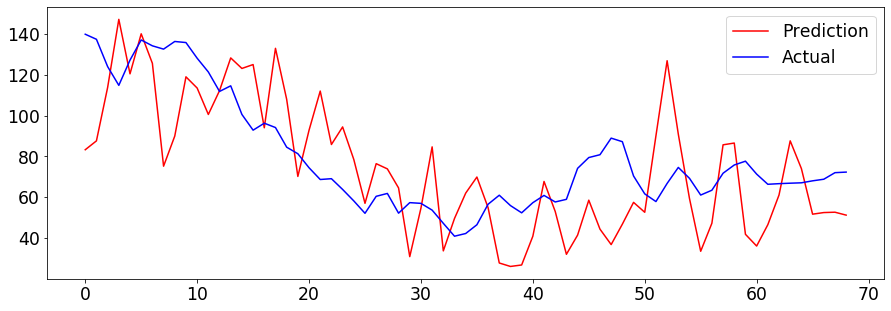

In [19]:
plt.figure(figsize=(15, 5));
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

In [20]:
import pandas as pd
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(newy_test)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

In [21]:
act_pred

,Predicted,Actual
0,83.257202,139.87
1,87.604187,137.39
2,113.770744,124.01
3,147.160629,114.82
4,120.460175,127.19
...,...,...
64,74.022942,67.05
65,51.678230,68.02
66,52.468437,68.80
67,52.642735,72.02


In [22]:
df[276:]

,price,Month,price_lag,price_diff,rolling_mean_price
date,,,,,
2013-03-31,139.87,3,154.64,4.15,305.13
2013-04-30,137.39,4,139.87,-14.77,294.51
2013-05-31,124.01,5,137.39,-2.48,277.26
2013-06-30,114.82,6,124.01,-13.38,261.40
2013-07-31,127.19,7,114.82,-9.19,238.83
...,...,...,...,...,...
2018-08-31,68.02,8,67.05,0.19,133.91
2018-09-30,68.80,9,68.02,0.97,135.07
2018-10-31,72.02,10,68.80,0.78,136.82


In [23]:
pred_price

array([[0.40862232],
       [0.43335906],
       [0.58226115],
       [0.7722679 ],
       [0.62032765],
       [0.73198855],
       [0.6496002 ],
       [0.36276776],
       [0.44676673],
       [0.61194694],
       [0.5807244 ],
       [0.5070103 ],
       [0.57337576],
       [0.66470677],
       [0.6353369 ],
       [0.64620376],
       [0.4698952 ],
       [0.6914512 ],
       [0.54934895],
       [0.33418745],
       [0.46305496],
       [0.5722748 ],
       [0.42321005],
       [0.4722397 ],
       [0.38143235],
       [0.259168  ],
       [0.36979306],
       [0.35520902],
       [0.30208448],
       [0.11051556],
       [0.24579641],
       [0.41658503],
       [0.12657005],
       [0.21700105],
       [0.2876399 ],
       [0.3324805 ],
       [0.24714059],
       [0.09275421],
       [0.08313393],
       [0.08720981],
       [0.1674061 ],
       [0.32014343],
       [0.23647878],
       [0.11697568],
       [0.17048724],
       [0.26795286],
       [0.18717334],
       [0.144